In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import chi2_contingency, chi2
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

# Проект: вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета. Помиимо этого, в компании провели A/B тестирование наборов акционных предложений. 
На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

# Задание 1
Retention – один из самых важных показателей в компании. 
Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 
Данные лежат в папке shared и имеют следующую структуру:
shared/problem1-reg_data.csv – данные о времени регистрации
shared/problem1-auth_data.csv – данные о времени захода пользователей в игру
Функция должна быть написана на python. 
В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [6]:
# Загрузим исходные данные по заходам пользователей в игру
auth = pd.read_csv('C:\Korchenkin\KC_Les\project_final\problem1-auth_data.csv', sep=';')

In [71]:
# Преобразуем данные из формата unixtime в формат datetime
auth['auth_ts'] = pd.to_datetime(auth.auth_ts, unit='s')
auth.head()

,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2


In [74]:
auth.shape

(9601013, 2)

In [8]:
# Выполним разведочный анализ данных
auth.describe(include = 'all')

C:\Users\User\AppData\Local\Temp\ipykernel_11052\2791540091.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  auth.describe(include = 'all')


,auth_ts,uid
count,9601013,9.601013e+06
unique,9180915,NaN
top,2020-07-25 21:05:03,NaN
freq,5,NaN
first,1998-11-18 09:43:43,NaN
last,2020-09-23 15:17:24,NaN
mean,NaN,3.347198e+05
std,NaN,2.832669e+05
min,NaN,1.000000e+00
25%,NaN,9.599700e+04


In [9]:
auth.dtypes

auth_ts    datetime64[ns]
uid                 int64
dtype: object

In [10]:
auth.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

In [11]:
auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [12]:
# Загрузим исходные данные по регистрациям пользователей
reg = pd.read_csv('C:\Korchenkin\KC_Les\project_final\problem1-reg_data.csv', sep=';')

In [72]:
# Преобразуем данные из формата unixtime в формат datetime
reg['reg_ts'] = pd.to_datetime(reg.reg_ts, unit='s')
reg.head()

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


In [75]:
reg.shape

(1000000, 2)

In [15]:
# Выполним разведочный анализ данных
# Применение метода describe() нецелесобразно в связи с характером данных (id и уникальная дата регистрации)
reg.dtypes

reg_ts    datetime64[ns]
uid                int64
dtype: object

In [16]:
reg.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [17]:
reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

#### Комментарии по итогам загрузки данных:
В массиве исходных данных отсутствуют пропущенные значения, данные представлены в необходимом формате, все id пользователей являются уникальными. Дальнейших преобразований данных не требуется. 
#### Дальнейшие шаги:
Построим график количества заходов пользователей в игру во времени. Для однозначного понимания изменим наименования столбцов.

In [92]:
# Извлечем информацию о дате из данных datetime
# Выполним группировку и агрегацию для построения графика, построим график
authfig = auth
authfig = authfig.rename(columns={"auth_ts": "date", "uid": "number_of_auth"})
authfig['date'] = authfig['date'].dt.date
authfig = authfig.groupby('date', as_index=False).agg({'number_of_auth': 'count'})
authfig.head()

,date,number_of_auth
0,1998-11-18,1
1,1999-07-22,1
2,1999-07-25,1
3,1999-07-31,1
4,1999-08-05,1


C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='number_of_auth'>

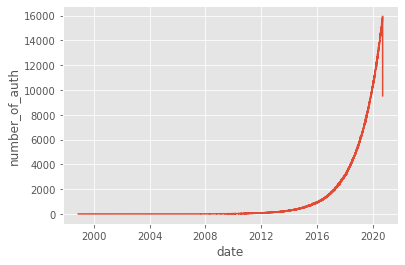

In [93]:
sns.lineplot(authfig.date, authfig.number_of_auth)

#### Комментарии по результатам разведочного анализа данных:
Данные по количеству заходов и регистрация охватывают период 1998-2020 годы. Данные полные, пропущенных значений нет.

В игровом приложении зарегистрировано 1 млн уникальных пользователей, что довольно много. Приложение является популярным.

Из данных по количеству пользователей и заходов (авторизаций) следует, что приходится в среднем 9 авторизаций на пользователя.

Спад на графике является чисто техническим и связан с наличием данных за последний день 23.09.20 только до 15:17 включительно

Можно выделить два этапа за период 1998-2020 гг.: низкая активность пользователей (1998 - 2015 гг.), рост популярности (2016-2020 гг.).

#### Дальнейшие шаги:
Выполним необходимые операции для построения показателя retention игроков (по дням от даты регистрации игрока). Выберем 2018 год, представляющий собой середину периода роста популярности приложения.  

In [21]:
# Выполним сортировку исходного массива заходов пользователей в игру для целей выделения тестового фрагмента в сенятбре 2018 г.
set_a = auth.query("auth_ts >= '2018-09-01' and auth_ts <= '2018-10-01'")
set_a

,auth_ts,uid
2766246,2018-09-01 00:00:25,126508
2766247,2018-09-01 00:00:32,284348
2766248,2018-09-01 00:00:43,202970
2766249,2018-09-01 00:00:54,316711
2766250,2018-09-01 00:00:56,321654
...,...,...
2906806,2018-09-30 23:58:39,326716
2906807,2018-09-30 23:59:09,100700
2906808,2018-09-30 23:59:24,337945
2906809,2018-09-30 23:59:39,78920


In [22]:
# Выполним сортировку исходного массива регистраций пользователей в игре для целей выделения тестового фрагмента в сенятбре 2018 г.
set_r = reg.query("reg_ts >= '2018-09-01' and reg_ts <= '2018-10-01'")
set_r

,reg_ts,uid
289600,2018-09-01 00:00:56,321654
289601,2018-09-01 00:03:58,321655
289602,2018-09-01 00:06:59,321656
289603,2018-09-01 00:10:00,321657
289604,2018-09-01 00:13:02,321658
...,...,...
304240,2018-09-30 23:47:54,337941
304241,2018-09-30 23:50:46,337942
304242,2018-09-30 23:53:39,337943
304243,2018-09-30 23:56:32,337944


In [23]:
# Объединим массивы, поставим первым столбцом дату регистрации, преобразуем дату в день для дальнейшего вычисления retention.
set_ra = set_r.merge(set_a,  how='inner', on='uid')
set_ra['auth_ts'] = set_ra['auth_ts'].dt.date
set_ra['reg_ts'] = set_ra['reg_ts'].dt.date
set_ra

,reg_ts,uid,auth_ts
0,2018-09-01,321654,2018-09-01
1,2018-09-01,321655,2018-09-01
2,2018-09-01,321656,2018-09-01
3,2018-09-01,321657,2018-09-01
4,2018-09-01,321658,2018-09-01
...,...,...,...
24321,2018-09-30,337941,2018-09-30
24322,2018-09-30,337942,2018-09-30
24323,2018-09-30,337943,2018-09-30
24324,2018-09-30,337944,2018-09-30


In [24]:
# Вычислим столбец, показывающий разность (разницу) в днях между датой регистрации и датой захода в игру для uid игрока.
# Добавим к вычисленной величине единицу для корректного учета захода пользователя в один день с регистрацией.
set_ra['difference'] = (set_ra['auth_ts'] - set_ra['reg_ts']).dt.days + 1
set_ra

,reg_ts,uid,auth_ts,difference
0,2018-09-01,321654,2018-09-01,1
1,2018-09-01,321655,2018-09-01,1
2,2018-09-01,321656,2018-09-01,1
3,2018-09-01,321657,2018-09-01,1
4,2018-09-01,321658,2018-09-01,1
...,...,...,...,...
24321,2018-09-30,337941,2018-09-30,1
24322,2018-09-30,337942,2018-09-30,1
24323,2018-09-30,337943,2018-09-30,1
24324,2018-09-30,337944,2018-09-30,1


In [25]:
# Сгруппируем информацию о заходах пользователей в игру по датам регистрации и разнице в днях вход-регистрация за выбранный месяц.
# Рассчитаем количество вошедших в игру уникальных пользователей, характеризующее  величину retention по дням.
cohorts_data = set_ra.groupby(['reg_ts', 'difference'], as_index=False).agg({'uid': 'nunique'})
cohorts_data

,reg_ts,difference,uid
0,2018-09-01,1,477
1,2018-09-01,2,6
2,2018-09-01,3,16
3,2018-09-01,4,22
4,2018-09-01,5,19
...,...,...,...
460,2018-09-28,2,10
461,2018-09-28,3,22
462,2018-09-29,1,499
463,2018-09-29,2,12


#### Комментарии: 
Массив состоит из 465 строк: действительно 01.09 - 1-30 значений, 02.09 - 1-29 значений, ... , 29.09 - 1-2 значения, 30.09 - 1 значение. В данном случае матрица 30х30 корректно отражает количество дней / периодов для учета входов пользователей в игру за выбранный период.
#### Дальнейшие шаги:
Воспользуемся обозначениями переменных, примененными в промежуточном проекте. Дата регистрации представляет собой когортную группу, а разница в днях является когорным индексом для расчета retention.

Для однозначного понимания изменим наименования столбцов. Расчитаем pivot таблицу - когортная группа / когортный индекс. Наконец, рассчитаем метрику retention. Принимая в таблице первый столбец за 100% рассчитаем метрику retention по дням от даты регистрации игрока.

In [27]:
cohorts_data = cohorts_data.rename(columns={"reg_ts": "cohort_group", "difference": "cohort_index"})
cohorts = cohorts_data.pivot(index='cohort_group', columns='cohort_index', values='uid')
cohorts

cohort_index,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
cohort_group,,,,,,,,,,,,,,,,,,,,,
2018-09-01,477.0,6.0,16.0,22.0,19.0,27.0,29.0,30.0,25.0,25.0,...,15.0,16.0,17.0,16.0,18.0,13.0,14.0,13.0,9.0,15.0
2018-09-02,477.0,9.0,15.0,23.0,24.0,31.0,25.0,28.0,23.0,26.0,...,21.0,27.0,21.0,15.0,18.0,14.0,24.0,9.0,18.0,NaN
2018-09-03,478.0,12.0,21.0,22.0,28.0,27.0,24.0,29.0,17.0,25.0,...,12.0,17.0,24.0,14.0,18.0,12.0,12.0,15.0,NaN,NaN
2018-09-04,479.0,10.0,23.0,25.0,19.0,37.0,33.0,32.0,22.0,28.0,...,22.0,21.0,16.0,17.0,23.0,10.0,17.0,NaN,NaN,NaN
2018-09-05,480.0,5.0,30.0,23.0,25.0,25.0,37.0,30.0,29.0,22.0,...,26.0,21.0,23.0,21.0,13.0,16.0,NaN,NaN,NaN,NaN
2018-09-06,481.0,7.0,26.0,27.0,21.0,24.0,28.0,26.0,15.0,28.0,...,19.0,21.0,13.0,15.0,12.0,NaN,NaN,NaN,NaN,NaN
2018-09-07,481.0,10.0,15.0,29.0,18.0,21.0,39.0,29.0,16.0,23.0,...,20.0,13.0,21.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-08,482.0,12.0,18.0,16.0,22.0,30.0,23.0,38.0,22.0,28.0,...,21.0,15.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-09,483.0,13.0,18.0,21.0,23.0,38.0,35.0,33.0,27.0,39.0,...,20.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# Рассчитаем метрику retention с использованием метода divide.
# Воспользуемся функцией ilock для выбора первого столбца в качестве делителя, зададим деление по столбцам (axis=0).
# Выразим в %, умножив на 100. 
retention = cohorts.divide(cohorts.iloc[:,0], axis=0).round(2)
retention

cohort_index,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
cohort_group,,,,,,,,,,,,,,,,,,,,,
2018-09-01,1.0,0.01,0.03,0.05,0.04,0.06,0.06,0.06,0.05,0.05,...,0.03,0.03,0.04,0.03,0.04,0.03,0.03,0.03,0.02,0.03
2018-09-02,1.0,0.02,0.03,0.05,0.05,0.06,0.05,0.06,0.05,0.05,...,0.04,0.06,0.04,0.03,0.04,0.03,0.05,0.02,0.04,NaN
2018-09-03,1.0,0.03,0.04,0.05,0.06,0.06,0.05,0.06,0.04,0.05,...,0.03,0.04,0.05,0.03,0.04,0.03,0.03,0.03,NaN,NaN
2018-09-04,1.0,0.02,0.05,0.05,0.04,0.08,0.07,0.07,0.05,0.06,...,0.05,0.04,0.03,0.04,0.05,0.02,0.04,NaN,NaN,NaN
2018-09-05,1.0,0.01,0.06,0.05,0.05,0.05,0.08,0.06,0.06,0.05,...,0.05,0.04,0.05,0.04,0.03,0.03,NaN,NaN,NaN,NaN
2018-09-06,1.0,0.01,0.05,0.06,0.04,0.05,0.06,0.05,0.03,0.06,...,0.04,0.04,0.03,0.03,0.02,NaN,NaN,NaN,NaN,NaN
2018-09-07,1.0,0.02,0.03,0.06,0.04,0.04,0.08,0.06,0.03,0.05,...,0.04,0.03,0.04,0.03,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-08,1.0,0.02,0.04,0.03,0.05,0.06,0.05,0.08,0.05,0.06,...,0.04,0.03,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-09,1.0,0.03,0.04,0.04,0.05,0.08,0.07,0.07,0.06,0.08,...,0.04,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Функция для расчета retention
Напишем функцию, которая будет считать метрику retention (по дням от даты регистрации игрока).
Зададим в качестве параметров функции начало и конец периода расчета retention.
Соберем вместе выполненные выше операции обработки данных. Включим визуализацию метрики retention.

In [30]:
start_of_period = '2019-09-01'
end_of_period = '2019-10-01'

In [88]:
def retention(start_of_period, end_of_period):
    auth = pd.read_csv('C:\Korchenkin\KC_Les\project_final\problem1-auth_data.csv', sep=';')
    auth['auth_ts'] = pd.to_datetime(auth.auth_ts, unit='s')
    reg = pd.read_csv('C:\Korchenkin\KC_Les\project_final\problem1-reg_data.csv', sep=';')
    reg['reg_ts'] = pd.to_datetime(reg.reg_ts, unit='s')
    set_a = auth.query("auth_ts >= @start_of_period and auth_ts <= @end_of_period")
    set_r = reg.query("reg_ts >= @start_of_period and reg_ts <= @end_of_period")
    set_ra = set_r.merge(set_a,  how='inner', on='uid')
    set_ra['auth_ts'] = set_ra['auth_ts'].dt.date
    set_ra['reg_ts'] = set_ra['reg_ts'].dt.date
    set_ra['difference'] = (set_ra['auth_ts'] - set_ra['reg_ts']).dt.days + 1
    cohorts_data = set_ra.groupby(['reg_ts', 'difference'], as_index=False).agg({'uid': 'nunique'})
    cohorts_data = cohorts_data.rename(columns={"reg_ts": "cohort_group", "difference": "cohort_index"})
    cohorts = cohorts_data.pivot(index='cohort_group', columns='cohort_index', values='uid')
    retention = cohorts.divide(cohorts.iloc[:,0], axis=0).round(2)
    plt.figure(figsize=(20, 14))
    plt.title('Retention')
    sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.1, cmap='rocket')
    plt.show()
    return retention

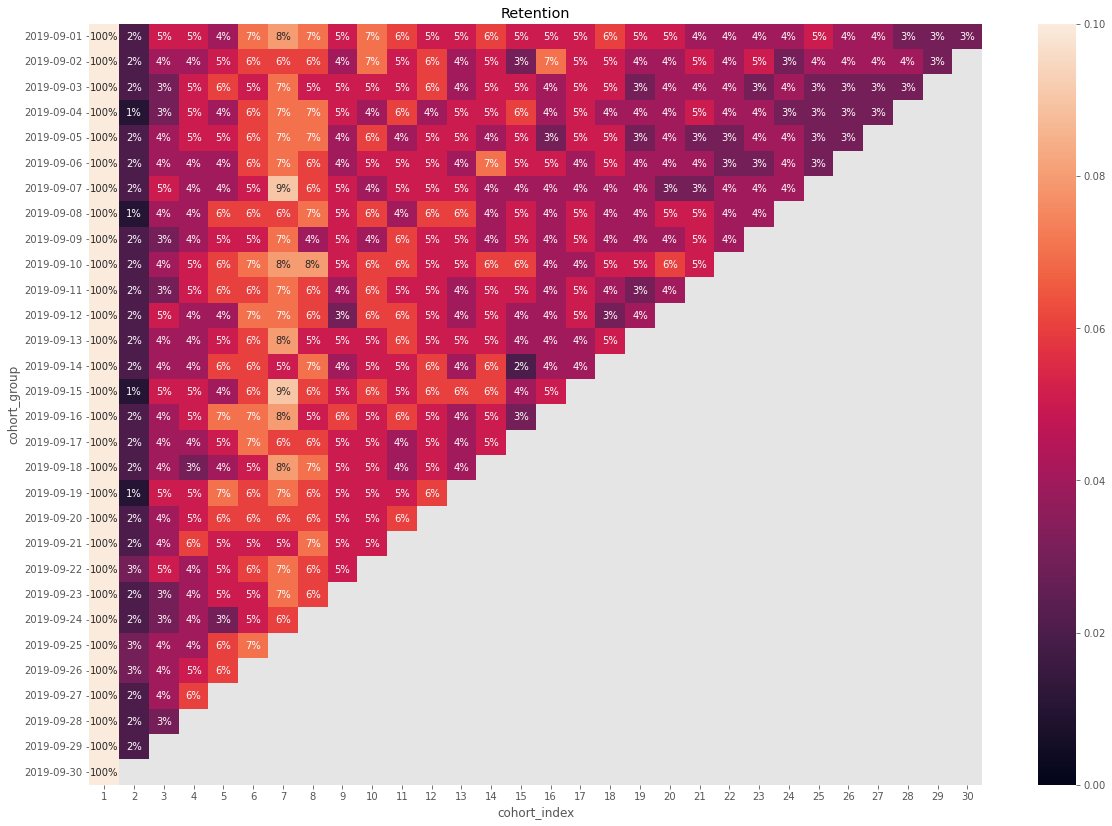

cohort_index,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
cohort_group,,,,,,,,,,,,,,,,,,,,,
2019-09-01,1.0,0.02,0.05,0.05,0.04,0.07,0.08,0.07,0.05,0.07,...,0.04,0.04,0.04,0.04,0.05,0.04,0.04,0.03,0.03,0.03
2019-09-02,1.0,0.02,0.04,0.04,0.05,0.06,0.06,0.06,0.04,0.07,...,0.05,0.04,0.05,0.03,0.04,0.04,0.04,0.04,0.03,NaN
2019-09-03,1.0,0.02,0.03,0.05,0.06,0.05,0.07,0.05,0.05,0.05,...,0.04,0.04,0.03,0.04,0.03,0.03,0.03,0.03,NaN,NaN
2019-09-04,1.0,0.01,0.03,0.05,0.04,0.06,0.07,0.07,0.05,0.04,...,0.05,0.04,0.04,0.03,0.03,0.03,0.03,NaN,NaN,NaN
2019-09-05,1.0,0.02,0.04,0.05,0.05,0.06,0.07,0.07,0.04,0.06,...,0.03,0.03,0.04,0.04,0.03,0.03,NaN,NaN,NaN,NaN
2019-09-06,1.0,0.02,0.04,0.04,0.04,0.06,0.07,0.06,0.04,0.05,...,0.04,0.03,0.03,0.04,0.03,NaN,NaN,NaN,NaN,NaN
2019-09-07,1.0,0.02,0.05,0.04,0.04,0.05,0.09,0.06,0.05,0.04,...,0.03,0.04,0.04,0.04,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-08,1.0,0.01,0.04,0.04,0.06,0.06,0.06,0.07,0.05,0.06,...,0.05,0.04,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-09,1.0,0.02,0.03,0.04,0.05,0.05,0.07,0.04,0.05,0.04,...,0.05,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
retention(start_of_period, end_of_period)

#### Заключительные комментарии:
Функция для расчета retention позволяет оценить работу приложения. В выбранный период (сентябрь 2018 г., середина периода роста популярности приложения) метрика достигает 5-9% на седьмой день после регистрации, далее снижается до 3-5% к концу месячного периода. 

Рассмотрим отраслевые бенчмарки. Публикация 15 Key Mobile Game Metrics That Developers MUST Track (ресурс https://www.blog.udonis.co приводит следующую информацию. 
According to GameAnalytics, here’s what the average user retention for the top 25%, median, and bottom 25% of mobile games was in 2020. Day 7 retention: 1.5% for the bottom 25% of games, 4% for median games, 8% for the top 25% of games. Day 30 retention: 0% for the bottom 25% of games, 1% for median games, 3% for the top 25% of games.

Можно отметить, что указанные выше значения метрики retention находятся на хорошем уровне в сравнении с отраслевыми бенчмарками.

# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [2]:
# Загрузим исходные данные.
abtst = pd.read_csv('C:\Korchenkin\KC_Les\project_final\problem2.csv', sep=';')
abtst

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [4]:
# Выполним разведочный анализ по всему массиву исходных данных.
abtst.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [5]:
abtst.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [6]:
abtst.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

#### Комментарии:
В массиве исходных данных отсутствуют пропущенные значения, представлен данные в числовом формате, все id пользователей являются уникальными. Дальнейшие преобразование данных не требуется.
#### Дальнейшие шаги:
Рассмотрим данные для контрольной и тестовой групп по отдельности. Под контрольной группой понимаем группу a, где не было изменений. Выполним разведочный анализ данных, рассмотрим данные на диаграммах распределения, проверим нормальность распределений. Под тестовой группой понимаем группу b, где был предложен акционный набор с изменениями. Обратим внимание на показатель выручки, представлящий важность для бизнеса. 

In [3]:
# Выберем данные по платящим пользователям для контрольной группы. Здесь и далее используем индекс "c" - control.
abc = abtst.query("testgroup == 'a' and revenue != 0")
abc.head()

,user_id,revenue,testgroup
72,73,351,a
341,342,290,a
385,386,250,a
416,417,37324,a
712,713,255,a


In [8]:
# Выполним разведочный анализ данных по платящим пользователям контрольной группы.
abc.shape

(1928, 3)

In [9]:
abc.describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


<AxesSubplot:xlabel='revenue', ylabel='Count'>

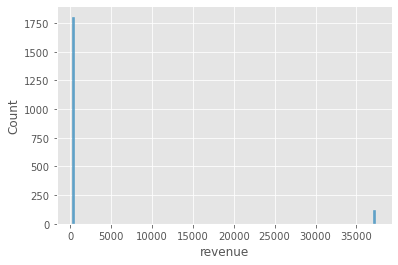

In [12]:
# Построим диаграмму распредеделения для показателя выручки.
sns.histplot(data=abc.revenue, bins=100)

In [13]:
# Проверим нормальность распределения. Определим H0 - распределение нормальное. Вероятность этого (p-value) мала. Отклоняем H0.
stats.normaltest(abc['revenue'])

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

#### Комментарии:
Диаграмма распределения показывает, что вероятность появления значений с высокой выручкой - низкая; вероятность появляения значений с низкой выручкой - высокая. 
Значение выручки в контрольной группе нестабильно. При понимании отличия распределения от нормального следует отметить, что среднеквадратичное отклонение превышает среднее значение по выручке в три раза.
#### Дальнейшие шаги:
Распределение выручки отличается от нормального.  Характер графика не позволяет отнести распределение выручки к какому-либо типу распределений. На графике можно выделить покупки пользователей с выручкой до 5000 рублей и выше 35000 рублей. Посмотрим на составляющие распределения с высокой и низкой выручкой для контрольной группы по отдельности. 

In [18]:
# Выделим отдельно часть контрольной выборки с выручкой на пользователя менее 5000 рублей, выполним разведочный анализ данных.
abc1 = abtst.query("testgroup == 'a' and revenue != 0 and revenue < 5000")
abc1.head()

,user_id,revenue,testgroup
72,73,351,a
341,342,290,a
385,386,250,a
712,713,255,a
1346,1347,230,a


In [19]:
abc1.shape

(1805, 3)

In [20]:
abc1.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,199923.686981,302.458172
std,116615.234772,57.914246
min,73.000000,200.000000
25%,98963.000000,254.000000
50%,199268.000000,305.000000
75%,298918.000000,352.000000
max,404768.000000,400.000000


<AxesSubplot:xlabel='revenue', ylabel='Count'>

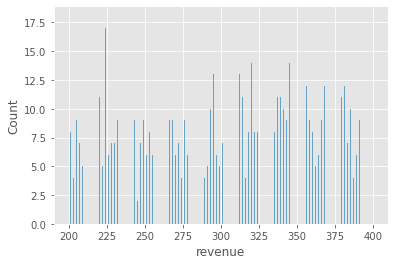

In [21]:
# Построим диаграмму распредеделения.
sns.histplot(data=abc1.revenue, bins=1000)

In [22]:
# Проверим нормальность распределения. Определим H0 - распределение нормальное. Вероятность этого (p-value) мала. Отклоняем H0.
stats.normaltest(abc1['revenue'])

NormaltestResult(statistic=1341.2009917493335, pvalue=5.779697118077758e-292)

In [23]:
# Выделим отдельно часть контрольной выборки с выручкой на пользователя более 5000 рублей, выполним разведочный анализ данных.
abc2 = abtst.query("testgroup == 'a' and revenue != 0 and revenue > 5000")
abc2.head()

,user_id,revenue,testgroup
416,417,37324,a
4428,4429,37304,a
5777,5778,37315,a
8065,8066,37307,a
8743,8744,37334,a


In [24]:
abc2.shape

(123, 3)

In [25]:
abc2.describe()

,user_id,revenue
count,123.000000,123.000000
mean,203513.073171,37319.121951
std,116745.137742,25.442183
min,417.000000,37293.000000
25%,109013.500000,37301.000000
50%,204560.000000,37311.000000
75%,317108.500000,37329.000000
max,399295.000000,37433.000000


<AxesSubplot:xlabel='revenue', ylabel='Count'>

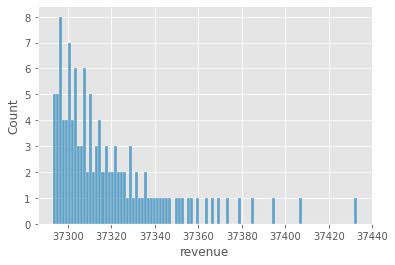

In [26]:
# Построим диаграмму распредеделения.
sns.histplot(data=abc2.revenue, bins=100)

In [27]:
# Проверим нормальность распределения. Определим H0 - распределение нормальное. Вероятность этого (p-value) мала. Отклоняем H0.
stats.normaltest(abc2['revenue'])

NormaltestResult(statistic=53.23469146381143, pvalue=2.7557107202646222e-12)

#### Комментарии:
Существующий ход бизнеса, который характеризуют данные по выручке в контрольной группе, позволяет привлекать в рамках акционной программы пользователей с низким чеком (200-400 рублей) и высоким чеком (37293-37433 рублей). При этом следует отметить, что нет покупок пользователей в пределах 401-37000 рублей, высокий чек связан с малой группой пользователей - 123 человека. 
#### Дальнейшие шаги:
Перейдем к рассмотрению тестовой группы. Выполним аналитику аналогично: выборка, разведочный анализ, диаграмма, тест на нормальность.

In [4]:
# Выберем данные по платящим пользователям для тестовой группы. Здесь и далее используем индекс "t" - test.
abt = abtst.query("testgroup == 'b' and revenue !=0")
abt.head()

,user_id,revenue,testgroup
160,161,3797,b
377,378,3768,b
386,387,3527,b
551,552,2038,b
913,914,3902,b


In [29]:
abt.shape

(1805, 3)

In [30]:
abt.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


<AxesSubplot:xlabel='revenue', ylabel='Count'>

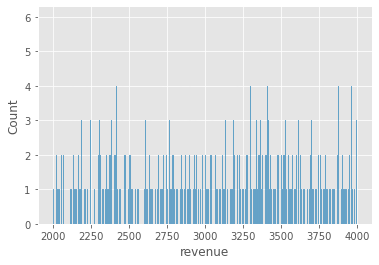

In [98]:
# Построим диаграмму распредеделения для тестовой группы.
sns.histplot(data=abt.revenue, bins=2000)

In [31]:
# Проверим нормальность распределения. Определим H0 - распределение нормальное. Вероятность этого (p-value) мала. Отклоняем H0.
stats.normaltest(abt['revenue'])

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

#### Комментарии: 
Изменчивость выручки в контрольной группе - низкая. Акционное предложение позволяет привлекать пользователей с чеком в пределах 2000-4000 рублей. Значение выручки стабильно.  Следует отметить равное количество пользователей в тестовой группе и контрольной группе с низким чеком.
#### Дальнейшие шаги:
Рассчитаем метрики для контрольной и тестовой групп: выручку, ARPU, ARPPU, Conversion rate (CR). Метрики являются стандартными для акционной программы и имеют прямую связь с бизнесом, выбор метрик ограничен наличием имеющихся данных.

In [32]:
# Рассчитаем выручку для контрольной группы.
abc.revenue.sum()

5136189

In [33]:
# Рассчитаем выручку для сегмента контрольной группы с высоким чеком.
abc2.revenue.sum()

4590252

In [34]:
# Рассчитаем ARPU для контрольной группы.
ARPUC = abc.revenue.sum() / 202103
ARPUC

25.413719736965806

In [35]:
# Рассчитаем ARPPU для контрольной группы (рассчитано ранее как среднее значение по выручке для группы).
ARPPUC = abc.revenue.sum() / 1928
ARPPUC

2663.9984439834025

In [36]:
# Рассчитаем конверсию для контрольной группы.
CRC = (1928 / 202103)*100
CRC

0.9539690157988748

In [37]:
# Рассчитаем выручку для тестовой группы.
abt.revenue.sum()

5421603

In [41]:
# Рассчитаем ARPU для тестовой группы
ARPUT = abt.revenue.sum() / 202667
ARPUT

26.75128659327863

In [42]:
# Рассчитаем ARPPU для тестовой группы (рассчитано ранее как среднее значение по выручке для группы).
ARPPUT = abt.revenue.sum() / 1805
ARPPUT

3003.6581717451522

In [43]:
# Рассчитаем конверсию для тестовой группы.
CRT = (1805 / 202667)*100
CRT

0.8906235351586593

In [44]:
# Наконец, рассмотрим на графике совместно выручку платящих пользователей контрольной и тестовой групп.
abct = abtst.query("revenue !=0")
abct.head()

,user_id,revenue,testgroup
72,73,351,a
160,161,3797,b
341,342,290,a
377,378,3768,b
385,386,250,a


In [46]:
# Массив содержит корректную сумму значений обеих выборок.
abct.shape

(3733, 3)

<AxesSubplot:xlabel='revenue', ylabel='Count'>

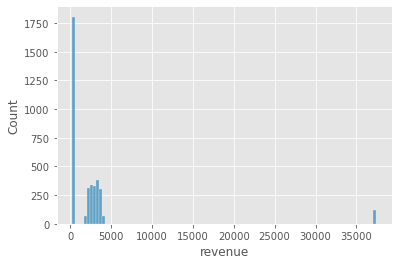

In [47]:
# Построим диаграмму распредеделения для обеих групп.
sns.histplot(data=abct.revenue, bins=100)

#### Комментарии: 
Измененение основных метрик для тестовой группы показывают смешанную и в основном позитивную тенденцию: произошло увеличение выручки, ARPU и ARPPU; однако, снизилась конверсия. 

Следует отметить для тестовой группы единообразие (стабильность) чека пользователей и рост медианного значения чека приблизительно в десять раз. Таким образом, выручка на пользователя тестовой группы примерно постоянна и её объем относительно равномерно распределен на 1800+ платящих пользователей. Для контрольной группы стабильность результатов акции зависит от поведениея 123 пользователей, на которых приходится 89% выручки. Такое распределение выручки в контрольной группе повышает риски бизнеса в акционных программах. С какой периодичностью пользователи будут готовы выполнять высокие акционные платежи повторно? 
#### Дальнейшие шаги:
Согласно заданию требуется оценить лучший набор акционных предложений, набор метрик и способов для такой оценки. Для этого определим статистическую значимость изменений.

С учетом отклонения от нормального распределений тестовой и контрольной групп целесообразно использовать тест Манна Уитни для выявления статистической значимости сходства / различия формы распределения. 

Изменение среднего чека возможно оценить с использованием методов t тест и бутстрап. Следует отметить, что применение t-тест является спорным в ситуации существенного (более чем в пятнадцать раз) отличия дисперсий выборок и отклонения распределений от нормального. Положительным фактором для применения t-тест являеся большой размер выборки (1928 и 1805 значений). Используем метод бутстрап дополнительно к t-тесту.

Наконец, изменение конверсии пользователя в оплату возможно оценить с помощью теста  хи-квадрат для категориальных переменных (оплатил / не оплатил).

#### Оценка распределений выручки методом U-тест Mann-Whitney
Тест проверяет, отличаются ли средние ранги между выборками тестовой и контрольной групп и, как итог, статистическую значимость сходства / различия распределений. 
Н0: распределение признака в первой выборке соответствует распределению признака во второй выборке.

In [49]:
stats.mannwhitneyu(abt['revenue'], abc['revenue'])

MannwhitneyuResult(statistic=3258025.0, pvalue=0.0)

#### Итоги, комментарии:
Значение p-value малое, отклоняем H0, распределение признака в первой выборке не соответствует распределению признака во второй выборке. Распределения выручки тестовой и контрольной групп отличаются статистически значимо. Данный результат явно подтверждает наличие в контрольной и тестовой группах отмеченных выше трех диапазонов по выручке пользователя 200-400, 2000-4000 и 37293-37433 рублей.

#### Оценка средних по выручке методом t-тест
Установим H0: в генеральной совокупности никакого различия между средними значениями нет

In [64]:
stats.ttest_ind(abt.revenue, abc.revenue)

Ttest_indResult(statistic=1.5917100176862002, pvalue=0.11153459157259504)

#### Итоги, комментарии:
Значение p-value выше принятого уровня значимости 0,05. Не можем отклонить нулевую гипотезу. Отличие средних значений в выборках не является статистически значимым.

#### Оценка средних по выручке методом бутстрап
Метод бутстрапа позволяет проверять / моделировать различные величины.
Смоделируем и проверим разницу между средним значениями в выборках.
 Н0: разница между средними значениями отсутствует, среднее значение разницы стремится к нулю.

In [7]:
# Объявим функцию, которая позволяет с помощью бутстрапа проверить гипотезу об отсутствии разницы в средних.
def get_bootstrap(
    abc, # числовые значения первой выборки
    abt, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = abc.sample(
            len(abc), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = abt.sample(
            len(abt), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

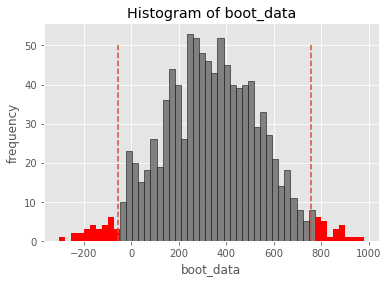

{'boot_data': [142.92745227066325,
  -27.443160998149324,
  215.62943500649408,
  392.2010953897079,
  220.444244319031,
  380.5430595625335,
  978.0868774496844,
  310.25019942299514,
  68.48608694152927,
  184.0455172929046,
  544.6491479982988,
  -10.021895437983403,
  206.96669722187107,
  340.86576361191237,
  376.3415029712305,
  269.3323772140552,
  323.5833932943301,
  533.4319306674638,
  297.87119084838105,
  491.33888374846265,
  708.4322200319534,
  204.24060757922325,
  392.1376418087152,
  234.15686227744527,
  236.8023499729884,
  167.8602625257181,
  586.26205790738,
  308.92805140170776,
  256.5926291077112,
  250.18828145653515,
  518.2589473109506,
  352.47112964218786,
  424.6690977689914,
  478.2888877714049,
  169.76374668107246,
  490.4993158124621,
  139.74466327973232,
  -55.77828070941723,
  390.23987080608276,
  175.50046551189098,
  310.72670687693244,
  190.54009551614354,
  628.2302591349521,
  246.54132682382942,
  428.50086665670506,
  260.5447839680005,

In [8]:
# Результаты расчетов функции:
get_bootstrap(abt.revenue, abc.revenue) # в результате хранится разница двух распределений, ДИ и pvalue

#### Итоги, комментарии:
Значение p-value выше принятого уровня значимости 0,05. Также из гистограммы видно, что нулевой интервал входит в принятый уровень значимости. Таким образом мы не можем отуклонить нулевую гипотезу. Расхождение между средними тестовой и контрольной выборок не является статистически значимым.

#### Оценка конверсии методом хи-квадрат
Используем для оценки категориальной переменной конверсии пользователей в оплату метод хи-квадрат. Установим H0 - нет различий в конверсии между старым a и новым b акционными наборами.

In [54]:
# При известных данных для расчета конверсии зададим таблицу сопряженности простым способом в виде массива.
T = np.array([[1928, 202103], [1805, 202667]])
T

array([[  1928, 202103],
       [  1805, 202667]])

In [56]:
# Рассчитаем статистику, p-value, количество степеней свободы. Функция принимает на вход таблицу сопряженности в виде массива.
stat, p, dof, expected = chi2_contingency(T)
stat, p

(4.294148751290091, 0.03824373651044168)

#### Итоги, комментарии:
Отклоняем нулевую гипотезу на уровне значимости 0,05. Различия в конверсии между старым a и новым b акционными наборами являются статистически значимыми.

#### Комментарии по оценке статистической значимости:

Метод Манна Уитни показал наличие статистической значимости для распределений выручки тестовой и контрольной групп. При этом в обоих группах визуально определимы на графике три непересекающихся диапазона по выручке пользователя 200-400, 2000-4000 и 37293-37433 рублей.

Метод хи-квадрат показал наличие статистической значимости по снижению показателя конверсии в оплату с 0,95 в контрольной группе до 0,86 в тестовой группе. 

Методы t-тест и бутстрап не подтвердили статистическую значимость увеличения средней выручки (ARPPU) с 2664 рублей в контрольной группе до 3004 рублей в тестовой группе.

Известно, что в случае асимметрии распределения и сильных выбросов классически применяемой мерой центральной тенденции является медиана. Важным отличием тестовой группы от контрольной является увеличение медианного чека с 311 до 3022 рублей. Значимость различия медианных чеков была подтверждена с помошью метода бутстрап. Код расчета не сохранен в задании; результаты 'quants': 0.025  2655.95 0.975  2760.00, 'p_value': 0.0

Таким образом, статистически значимым результатом исследовании акционных предложений является отличие распределений выручки тестовой и контрольной групп, существенное увеличение медианного чека и некоторое снижение конвесии в покупку для пользователей тестовой группы.

### Общие выводы:
Задание требует определить лучший набор предложений, метрики и методологию их анализа. Метрики и методология подробно описаны по ходу исследования. Определить лучший набор предложений не представляется возможным. Результаты обработки имеющихся данных противоречивы. 

Статистическая значимость повышения ARPPU (средний чек) не подтверждена, при этом статистически значимо снизилась конверсия в покупку в тестовой группе. 

Следует отметить повышенный риск для бизнеса сегмента пользователей контрольной группы с высоким чеком. В данном сегменте сконцентрированы 89% выручки контрольной группы. Распределения выручки для контрольной группы в целом и для сегмента с высоким чеком являются сильно скошенными влево. С какой периодичностью пользователи с высоким чеком готовы к повторным высоким акционным платежам?

Общепринятым показателем для ведения бизнеса является ценность (value). Value может иметь различия в формуле расчета, но по смыслу эквивалентна величине оплаты покупателем / пользователем за товар. В нашем случае выручка отличается в пятнадцать раз между медианными чеками в контрольной и тестовой группах, а также отличается в 100+ раз между низким и высоким чеками в контрольной группе. Как возможно увеличение ценности для пользователя в 100+ раз в рамках одной группы? Корректно ли сформированы группы?

Наличие в контрольной и тестовой группах трех диапазонов по среднему чеку - 200-400, 2000-4000, 37293-37433 рублей - позволяет выделить три сегмента пользователей акции. Основной рекомендацией по итогам эксперимента является взаимодействие с пользователями во всех трех сегментах с целью формирования отдельного адресного предложения для каждого сегмента. После определения сегментов и порядка работы с ними целесообразно повторное проведение АВ теста с измененным составом пользователей и групп. 

# Задание 3:
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события? Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

#### Вводные комментарии:
В задании предлагается обосновать выбор метрик для оценки результатов тематических событий в игре Plants & Gardens. Был выполнен поиск игры по запросу "game plants & gardens скачать". Цель поиска - посмотреть на игру "вживую", составить собственное впечатление о возможных сценариях игры. Поиск не дал результатов. Судя по всему, игра не существует в реальности. 
Далее был выполнен поиск игр-аналогов. Цель поиска - найти игру, в сценарий которой могли быть встроены указанные в задании тематические события. Использовался ресурс https://screenrant.com с публикацией (обзор игр) 10 Best Games For Gardening & Plant Lovers.

Следующим шагом был выполнен поиск метрик для игр. Цель - найти распространенные в индустрии метрики, определить возможность их применения для решения задания. В данном случае были использованы ресурсы https://www.indeed.com/ с публикацией What Are Game Metrics and Do They Matter? и https://www.blog.udonis.co с публикацией 15 Key Mobile Game Metrics That Developers MUST Track. Перечни метрик указаны ниже в Приложении к заданию. Метрики приводятся без перевода и подробного описания в последовательности, представленной в публикации. Порядок расчета метрик комментируется при необходимости. 

Обоснования по выбору метрик касаются в большей степени взаимодействия пользователей с игрой при проведении тематических событий. Не уделяется отдельного внимания модели монетизации. В первую очередь метрики должны быть направлены на поддержание и мониторинг заинтересованности и благоприятных впечатлений пользователя. Полагаю, что благоприятные впечатления, опыт от взаимодействия с игрой приведут к росту монетизации.

Наконец, выбор метрик не подразумевает выстраивание их иерархии, рекомендаций по изменению системы метрик во времени. Для этого требуется понимание стратегии развития игры, что достаточно сложно определить исходя из ограниченного объема информации в задании и отсутствия игры Plants & Gardens в реальности. 

#### Возможные пользовательские сценарии  Plants & Gardens:

Для определения метрик успешности тематических событий важно обсудить возможные пользовательские сценарии игры Plants & Gardens. Здесь следует отметить различие тематических событий с точки зрения риска для пользователя. Согласно заданию в первом случае требуется пройти ряд уровней за определенное время (Сценарий 1 - С 1). Во втором случае при неудаче игрок будет откатываться на несколько уровней назад (Сценарий 2 - С 2). Решение об участии в тематическом событии зависит от наклонностей, "портрета" пользователя. Согласно многим исследованиям (классический пример - Д. Канеман, А. Тверски) человек не склонен к риску. В публикациях ученых приводится, например, ситуация, в которой большинство предпочитает гарантированно получить 800 долларов, нежели рискнуть и выиграть 1000 долларов с вероятностью 85% и с вероятностью в 15% не выиграть ничего. При этом математически ожидаемый денежный выигрыш во втором варианте выше (1000 х 0,85 + 0 х 0,15 = 850).

Обсудим возможные пользовательские сценарии игры Plants & Gardens. Воспользуемся обзором игр 10 Best Games For Gardening & Plant Lovers. В публикации приводятся две игры, уместные в качестве аналога. Первая - Stardew Valley, вторая - Reap. В первой игре пользователь находится в сценарии, когда он получает ферму в наследство и, далее, приводит ее в порядок, обустраивает, ведет хозяйство. Возможной целью является "work to expand their property and make a profit". Во второй игре пользователь попадает в более рискованный сценарий, "that turns gardening into a means of survival instead of relaxation. The nameless protagonist in the game has woken up on an island after a shipwreck, with only a few tools and some turnips." 

Подробности сценариев существующих игр и комментарии относительно несклонности человека к риску приводятся с целью определить уместность сценариев С 1 и C 2 игры Plants & Gardens для разных групп пользователей. Можно предположить, что играющие С 1 скорее должны быть ближе к Stardew Valley, а играющие С 2 скорее должны бы выбрать Reap. Более того, в игре Reap сценарий С 2 ("все или ничего") может быть единственно возможным. Таким образом, указанные в задании сценарии тематических событий С 1 и С 2 могут в принципе входить в противоречие, исходя из общей логики Plants & Gardens и предполагаемых наклонностей, "портретов" пользователей. В итоге, базовой рекомендацией - "нулевой метрикой" является уместность С 1 и С 2 для игры в целом и согласованность тематических событий с "портретом" пользователя.

#### Метрики результативности тематических событий:
Целесообразно связать метрики результативности тематических событий с целями пользователя и, вероятно, героя игры. Так, например, целями пользователя можно считать получение "правильных" эмоций. Целью героя, очевидно, является приобретение необходимых ресурсов на периодической основе.

В качестве персональных метрик возможно использовать Session length, Session Count, связанные с участием конкретного пользователя. Измерять востребованность события среди пользователей в целом можно с помощью DAU, Concurrent users, Total playtime. 

События проводятся ежемесячно. Для измерения во времени динамики поведения пользователей, участвующих в событиях удобно использовать когортный анализ для, например, Retention rate. С использованием когортного анализа можно анализировать и метрики монетизации, например, TTP – Time to purchase. С помощью TTP мы проверим, совершает ли участник тематического события покупки быстрее (при их наличии в игре). 

Как я уже упоминал выше, сценарий для события С 2 связан с повышенным риском для пользователя Plants & Gardens. Я считаю неподходящим данный сценарий, если Plants & Gardens подобна Stardew Valley. В случае проведения события по С 2 требуется уделять внимание метрикам "благополучия" пользователя. Это можно сделать с помощью классический метрики Churn rate, а также менее распространённый Start, fail and complete (описание - см. Приложение). Start, fail and complete позволяет разработчикам понять сложность прохождения игры и корректировать тематические события при необходимости.
С точки зрения достижения целей и "благополучия" героя игры логично отслеживать "размер имущества", приобретенного в рамках события. С точки зрения "портрета" пользователя размер имущества можно увязать со склонностью к риску, оттоком, динамикой прохождения игры. "Размер имущества" не представлен в перечнях метрик Приложения, детали нужно прорабатывать.

#### Заключение:
Результативность тематических событий можно оценивать с помощью метрик Session length, Session Count, DAU, Concurrent users, Total playtime. Для контроля динамики поведения пользователей подойдут когортный анализ для Retention rate и метрики монетизации Time to purchase. 

Тематические события должны быть уместны в контексте общего сценария игры и "портретов" пользователей. "Благополучие" пользователей позволит отслеживать Churn rate. 

Метрикам "благополучия" должно уделяться повышенное внимание в рамках тематического события по сценарию С 2. Для контроля прохождения игры дополнительно к Churn rate целесообразна метрика Start, fail and complete. Предлагаю также подумать над использованиме метрики "размер имущества" с учетом указанных выше коментариев. 

В публикации What Are Game Metrics and Do They Matter? указаны способ и цель применения метрик: Game metrics is a term that refers to raw telemetry data that a database stores and converts into values that allow developers to measure their game's performance. Полагаю, что приведенные выше подходы и рекомендации могут быть применены для развития игры Plants & Gardens.

#### Приложение:
- 15 Key Mobile Game Metrics That Developers MUST Track

Installs, DAU – Daily Active Users, MAU – Monthly Active Users, Stickiness Rate (DAU/MAU), RR – Retention Rate, CR – Churn Rate, ARPU – Average Revenue Per User,  LTV – Lifetime Value, ATV – Average Transaction Value, TTP – Time to purchase,  CPI – Cost Per Install, Session Length, Session Count, Install Source, eCPM (Effective Cost Per Mille).

- What Are Game Metrics and Do They Matter?

Daily active users, Session length, Installs,  First payment conversion, Retention rate, Customer satisfaction score,  Average revenue per user, Monthly active users, Churn rate, Concurrent users,  Total playtime, User acquisition cost, Customer lifetime value, Average transaction value, Start, fail and complete

Start, fail and complete

Start, fail and complete is a term that refers to three metrics that track how users engage with content. This set of data represents how many users start playing a piece of content, how many cannot complete it and give up, and how many successfully complete it. This metric is typically used to measure how difficult a piece of content is. If many users are engaging with a part of a game but ultimately give up before completing it, that can mean that it's too hard and causing frustration.